# Import Library

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import usrLibrary as lib
import cv2 as cv

# Setting Optical, Aperture, and Particle Condition

In [2]:
class optical_condition:
    L:      float # distance from the sample plane to the detector plane
    p:      float # pixel size of the detector
    Npixel: int   # window size of the probe function, object functions, and diffraction patterns
    energy: float # x-ray energy of the incident beam
    h:      float # plank constant
    c:      float # velocity of the light
    lamb:   float # wavelength
    k:      float # wavenumber
    dx:     float # pixel resolution at the sample plane
    DR:     float # dynamic range of the detector, for example opt.DR = log10{1e7 (photons) / 1 (photon}
    Wnoise: bool  # flag to apply photon shot noise to each calculated diffraction pattern


opt         = optical_condition()

opt.L       = 3                                         # unit: m
opt.p       = 75e-6                                     # unit: m
opt.Npixel  = 1024                                      # unit: pixel
opt.energy  = 5000                                      # unit: eV (electronVolt)
opt.h       = 6.62607015e-34                            # unit: m^2 kg/s
opt.c       = 299792458                                 # unit: m/s
opt.lamb    = (opt.h * 6.242e18) * opt.c / opt.energy   # unit: m
opt.k       = 2 * np.pi / opt.lamb                      # unit: 1/m
opt.dx      = opt.L * opt.lamb / (opt.Npixel * opt.p)   # unit: m/pixel
opt.DR      = 7
opt.Wnoise  = True

In [3]:
class aperture_condition:
    sideNumber:         int     # number of the side
    sideLength:         float   # length of a side
    Lpropagation:       float   # distance from the aperture to the sample
    needPropagation:    bool    # flag whether propagation from the aperture to the sample is needed

aper = aperture_condition()

aper.sideNumber     = 3     # input: 3 --> Triangle
aper.sideLength     = 5e-6  # unit: m
aper.Lpropagation   = 5e-4  # unit: m, range: # 500-1000*10^-6

if aper.Lpropagation > 0:
    aper.needPropagation = True
else:
    aper.needPropagation = False

In [4]:
class particle_condition:
    beta_Au:    float # parameter related to the absorption of the wavefield
    delta_Au:   float # parameter related to the phase shift of the wavefield
    diameter:   float # diameter of the gold nanoparticle
    ratio:      float # (Area occupied with gold nanoparticles) / (Area of the window, Npixel x Npixel)
    number:     int   # total number of the gold nanoparticles within the window
    velocity:   float # displacement of the gold nanoparticles (per frame)

par = particle_condition()

par.beta_Au     = 2.633e-5
par.delta_Au    = 1.2143e-4
par.diameter    = 300e-9 #300e-9 # unit: m
par.ratio       = 100e-3
par.number      = int(np.floor((opt.Npixel * opt.dx)**2 / (np.pi * (par.diameter / 2)**2) * par.ratio))
par.Nframe      = 2
par.velocity    = 10 * opt.dx    # unit: m/frame

**Note**:

datebase to get the parameters about the beta and delta for differenct material or X-ray energy...
https://henke.lbl.gov/optical_constants/pert_form.html

# Function Calculation

1. Object function
2. Probe function
3. Diffraction pattern

In [19]:
# set different seed per 5 frame
np.random.seed(1)

aperture = lib.calcAperture(opt, aper)
smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
if aper.needPropagation == 1:
    inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
else:
    inwave = aperture

AuNPimg = lib.calcAuNP(opt, par)

wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

difImg       = np.abs(wavedetector)**2

# diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount     = difImg.max()
difImg       = difImg / maxCount * 10**(opt.DR)
isCounted    = np.where(difImg >= 1, 1, 0)
difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

# 2-4-3, apply photon shot noise if "opt.Wnoise" is True
if opt.Wnoise == 1:
    difImgWnoise = np.random.poisson(difImg)

0
1


# Show Aperture

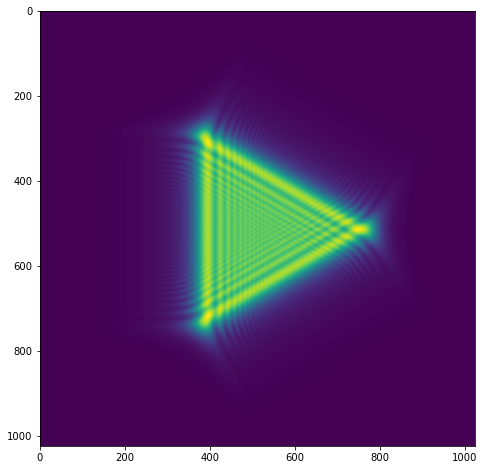

In [6]:
fig = plt.figure(figsize = [8, 8])
plt.imshow(np.abs(inwave))

# Flipping the Particle

Original Particle

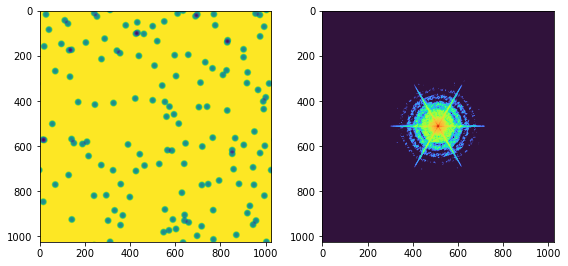

In [7]:
fig = plt.figure(figsize = [8, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.abs(AuNPimg[:, :, 0]))

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.log(difImg[:,:,0]+1e-5),cmap='turbo')

plt.tight_layout()
plt.show()

## Flipping Vertical

In [22]:
aperture = lib.calcAperture(opt, aper)
smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
if aper.needPropagation == 1:
    inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
else:
    inwave = aperture

AuNPimg2 = np.flip(AuNPimg,0)

wavesample2 = AuNPimg2 * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
wavedetector2 = np.fft.fftshift(np.fft.fft2(wavesample2, axes = (0, 1)), axes = (0, 1))

difImg2       = np.abs(wavedetector)**2

# diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount2     = difImg2.max()
difImg2       = difImg2 / maxCount * 10**(opt.DR)
isCounted2    = np.where(difImg2 >= 1, 1, 0)
difImg2       = difImg2 * isCounted # pixels which count lower than 1 photon is set to 0

# 2-4-3, apply photon shot noise if "opt.Wnoise" is True
if opt.Wnoise == 1:
    difImgWnoise2 = np.random.poisson(difImg)

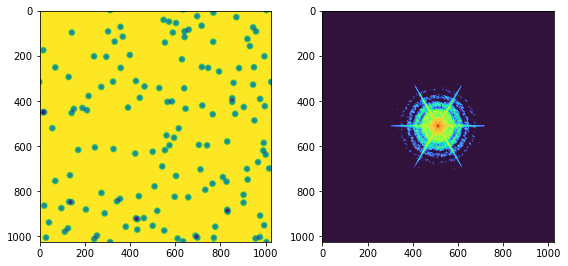

In [23]:
AuNPimg_flipv = np.flip(AuNPimg[:, :, 0],0)
difImg_flipv = np.flip(difImg[:,:,0],0)

fig = plt.figure(figsize = [8, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.abs(AuNPimg_flipv))


ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.log(difImg_flipv+1e-5),cmap='turbo')

plt.tight_layout()
plt.show()

## Flipping Horizontal

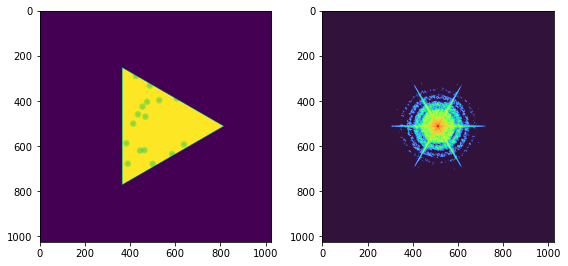

In [9]:
AuNPimg_fliph = np.flip(AuNPimg[:, :, 0],1)
difImg_fliph = np.flip(difImg[:,:,0],1)

fig = plt.figure(figsize = [8, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.abs(AuNPimg_fliph)*aperture)


ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.log(difImg_fliph+1e-5),cmap='turbo')

plt.tight_layout()
plt.show()

# Compare the Diffraction

## Between original and flip vertical

In [26]:
diff_v = np.subtract(difImg[:, :, 0],difImg2[:, :, 0])
print(np.count_nonzero(diff_v))
print(np.nonzero(diff_v))

0
(array([], dtype=int64), array([], dtype=int64))


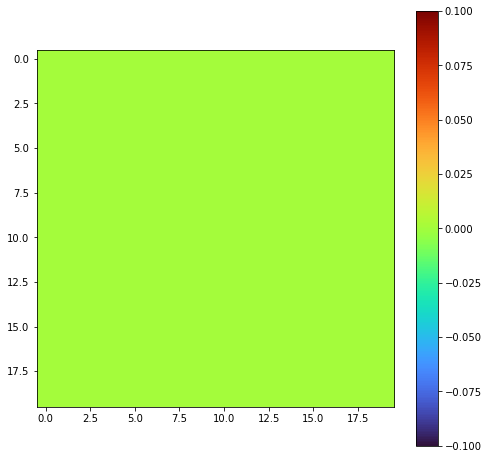

In [27]:
x = 10
fig = plt.figure(figsize = [8, 8])

plt.imshow(diff_v[512-x:512+x,512-x:512+x],cmap='turbo')

plt.colorbar()

In [56]:
diff_h = np.subtract(difImg[:, :, 0],difImg_fliph)
print(np.count_nonzero(diff_h))
print(np.nonzero(diff_h))

43874
(array([326, 326, 327, ..., 696, 697, 697]), array([404, 619, 405, ..., 617, 405, 618]))


# Without Aperture

## Original

In [59]:
wavesample = AuNPimg
wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

difImg       = np.abs(wavedetector)**2

# diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount     = difImg.max()
difImg       = difImg / maxCount * 10**(opt.DR)
isCounted    = np.where(difImg >= 1, 1, 0)
difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 

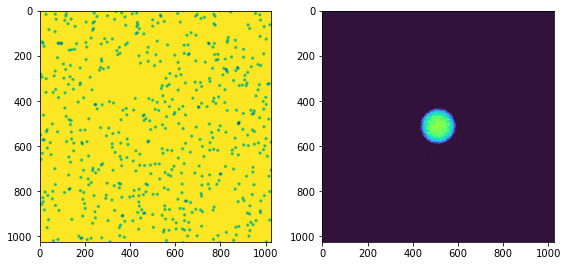

In [60]:
fig = plt.figure(figsize = [8, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.abs(AuNPimg[:, :, 0]))

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.log(difImg[:,:,0]+1e-5),cmap='turbo')

plt.tight_layout()
plt.show()

## Flipping Vertical

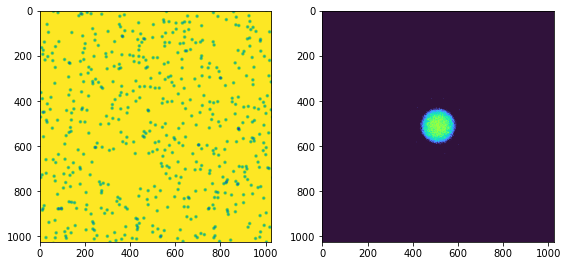

In [58]:
AuNPimg_flipv = np.flip(AuNPimg[:, :, 0],0)
difImg_flipv = np.flip(difImg[:,:,0],0)

fig = plt.figure(figsize = [8, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.abs(AuNPimg_flip))


ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.log(difImg_flipv+1e-5),cmap='turbo')

plt.tight_layout()
plt.show()